# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## 1. Подготовка данных

Установим и импортируем библиотеки

In [1]:
!pip install sweetviz

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install scikit-learn==1.1.3

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sweetviz as sv

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# Отключим оповещения
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

# Зададим константы, которые будем использовать во всём проекте.
RANDOM_STATE = 42

### 1.1. Загрузим данные из файла в переменную data

Данные загружены

### 1.2. Посмотрим основную информацию о датафреймах, воспользуемся функцией

In [6]:
def show_main_info (df):
    # print(df.name)
    display(df.head())
    display(df.describe(include = 'all'))
    # display(df.describe())
    display(df.info())
    print('\nДубликатов:', df.duplicated().sum())
    print('\nПропущенные значения:')
    # display(100*df.isna().sum().sort_values(ascending=False)/df.shape[0])
    display(df.isna().sum().sort_values(ascending=False))
    
    # display(df.corr())
    # PhiK Correlation
    
    # phik_overview = df.phik_matrix();
    # display(phik_overview.round(2))
    
    # plot_correlation_matrix(phik_overview.values, 
    #                         x_labels=phik_overview.columns, 
    #                         y_labels=phik_overview.index, 
    #                         vmin=0, vmax=1, color_map="Blues", 
    #                         title=r"correlation $\phi_K$", 
    #                         fontsize_factor=1, 
    #                         figsize=(8, 6));
    # plt.tight_layout();
    
    df.hist(figsize=(15, 8), bins=50, layout=(2,4));
    
    print('\n\n---------------------------------------------------------------------\n')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None


Дубликатов: 4

Пропущенные значения:


Repaired             71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64



---------------------------------------------------------------------



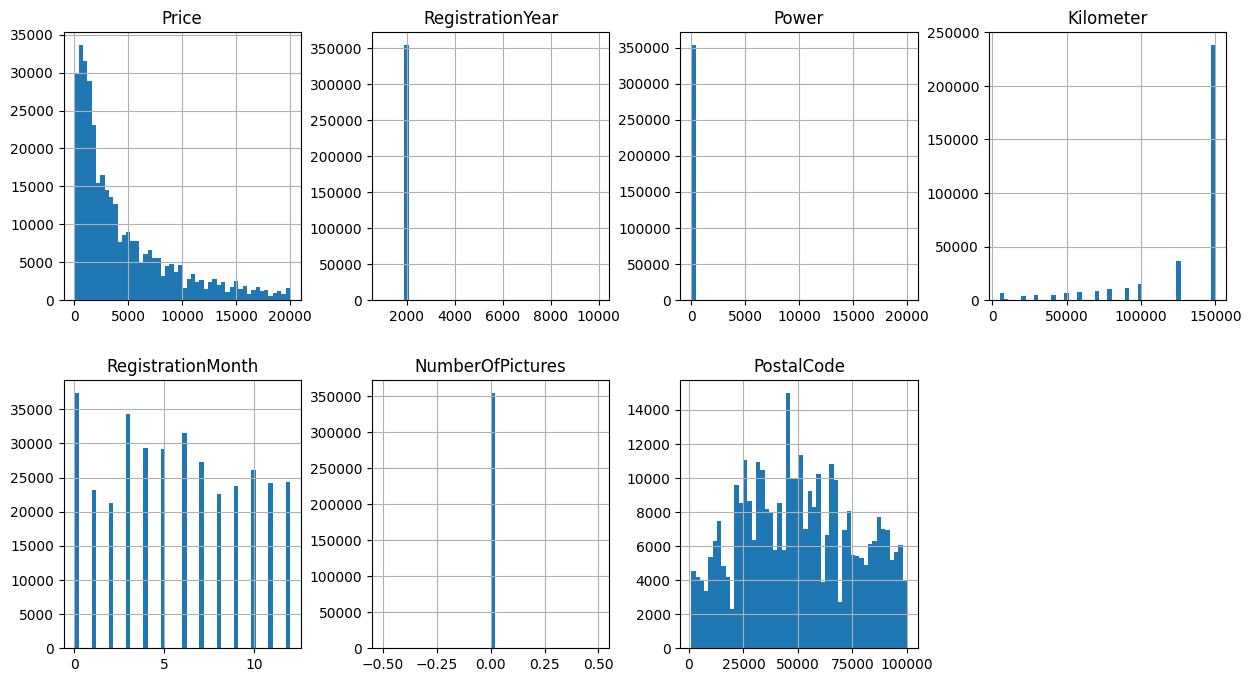

In [7]:
show_main_info(data)

                                             |          | [  0%]   00:00 -> (? left)


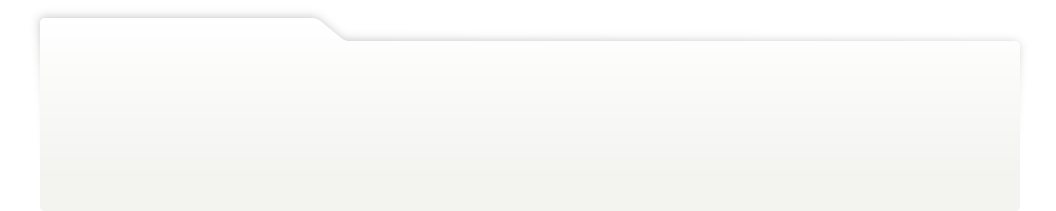
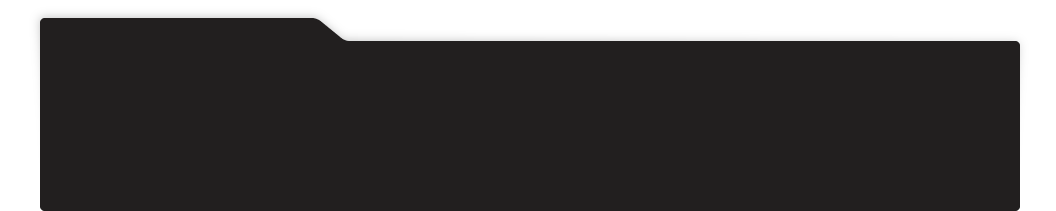
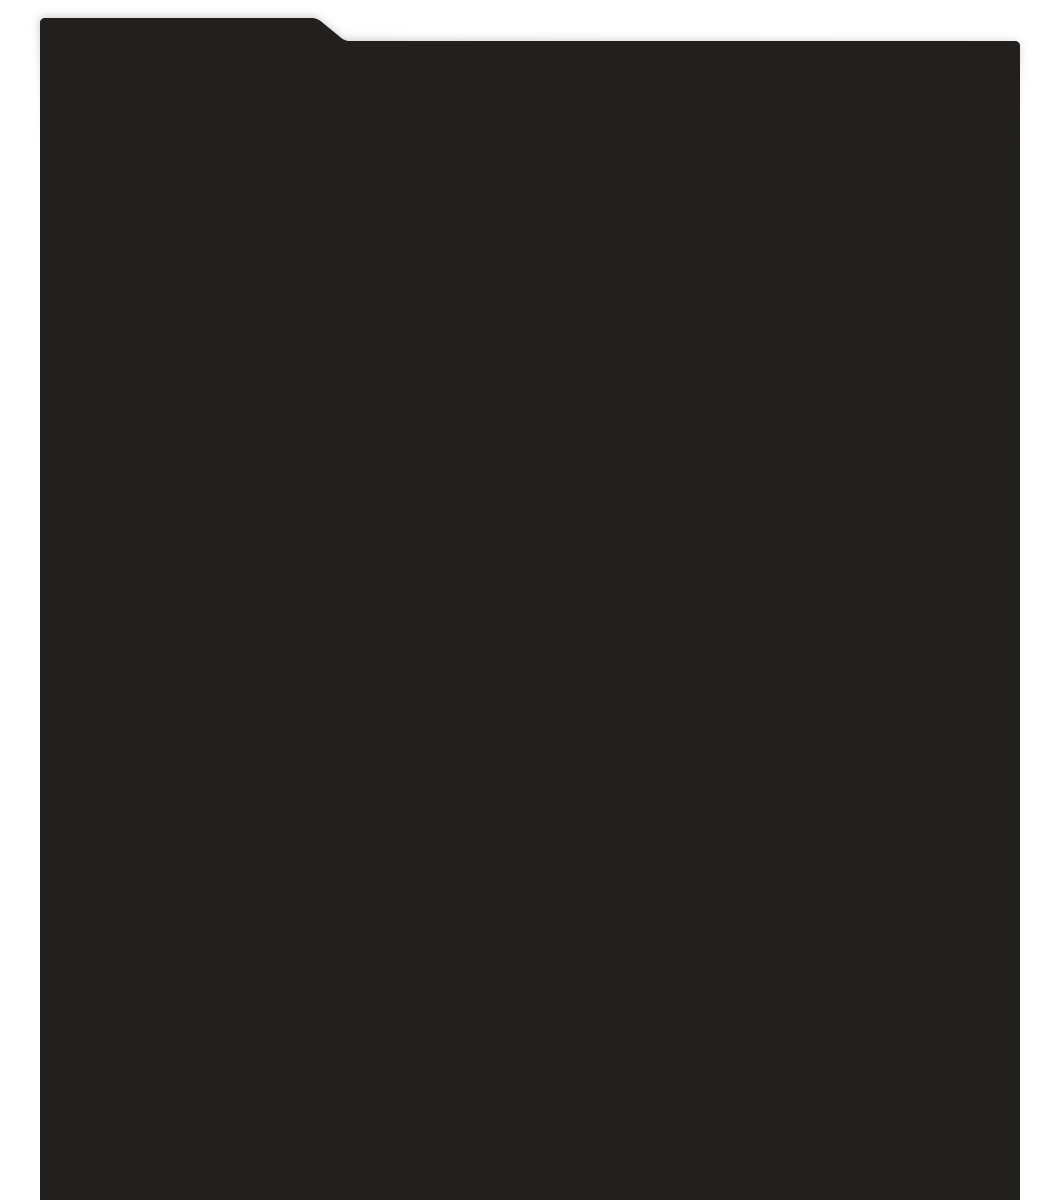
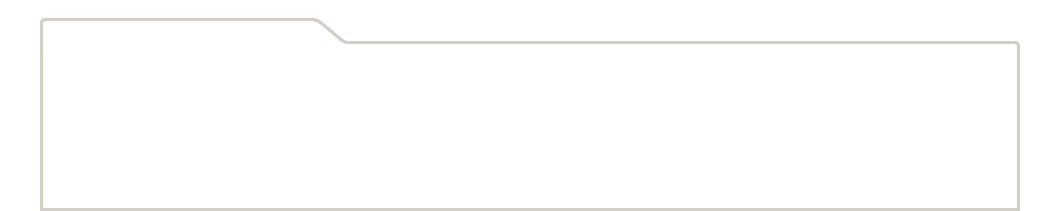
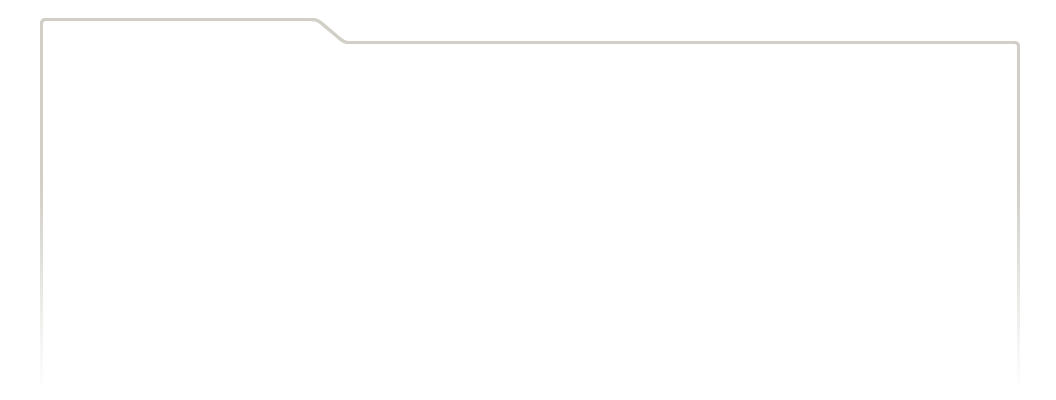
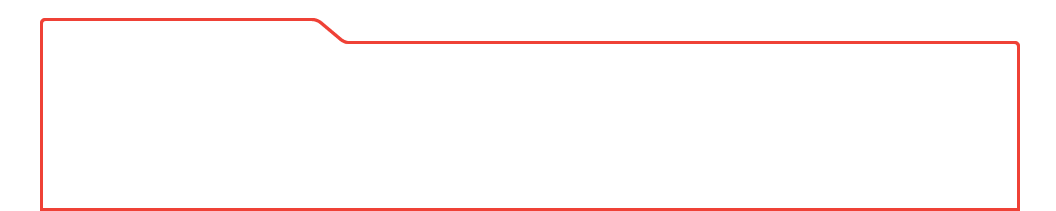
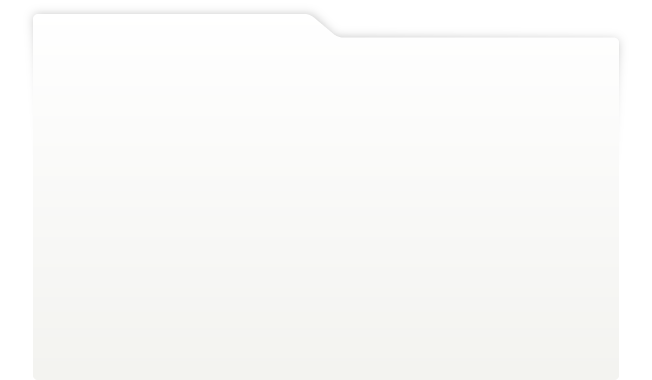
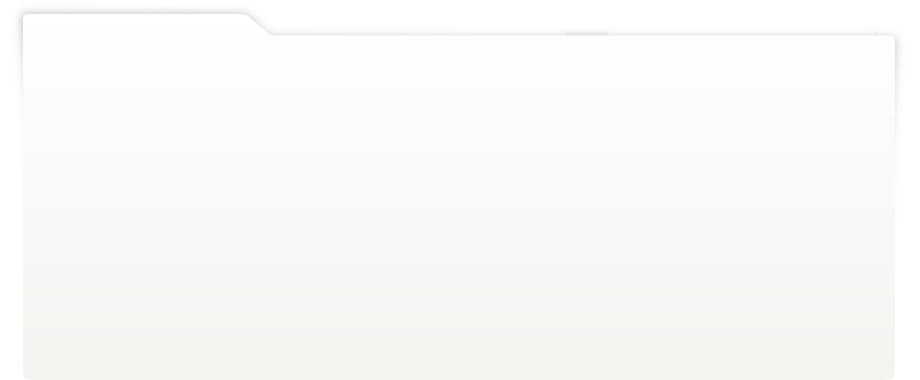
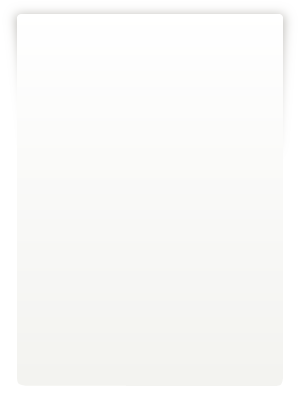
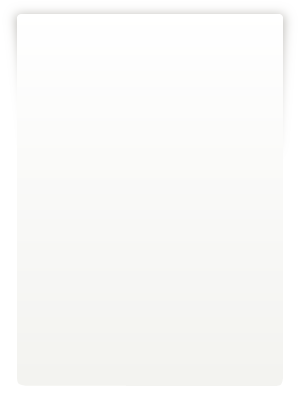
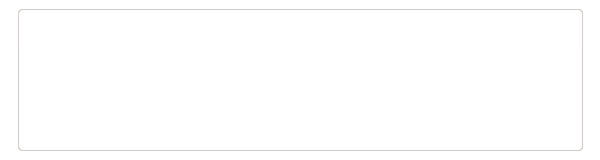
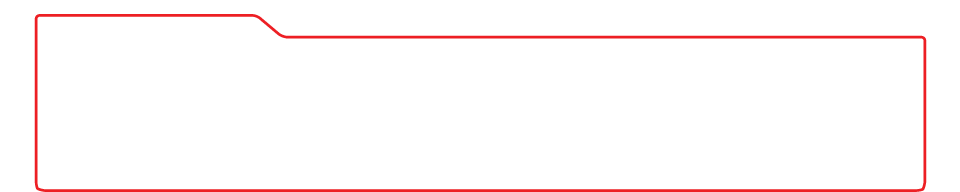
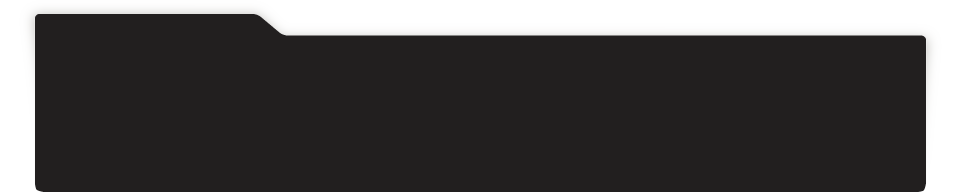
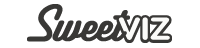
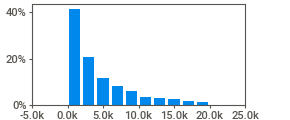
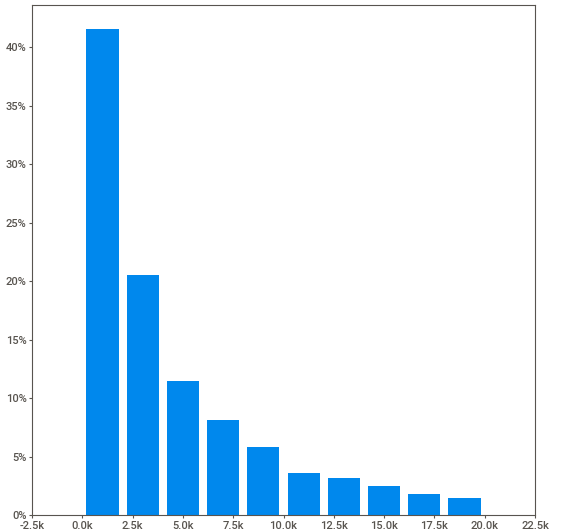
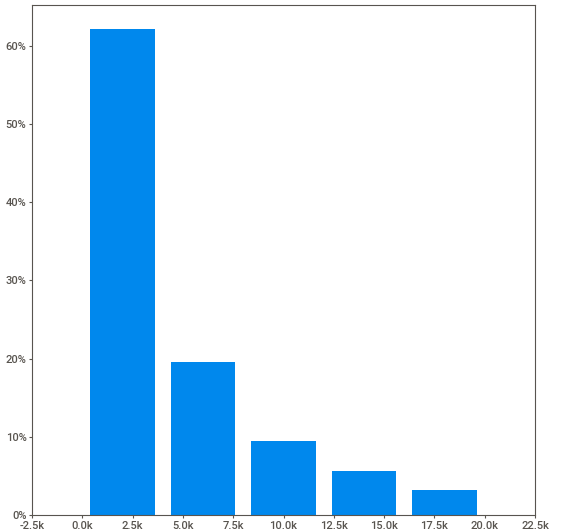
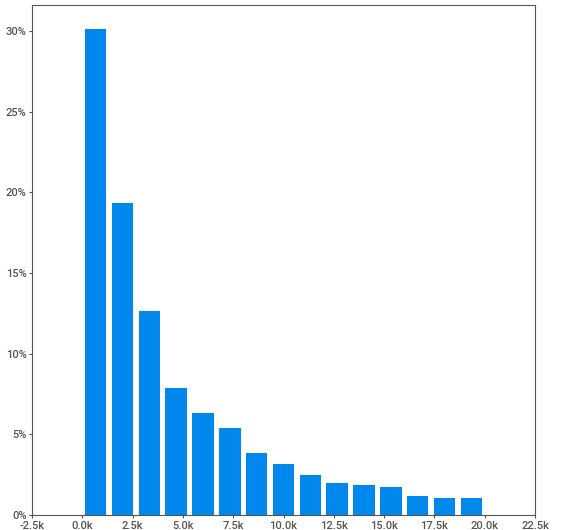
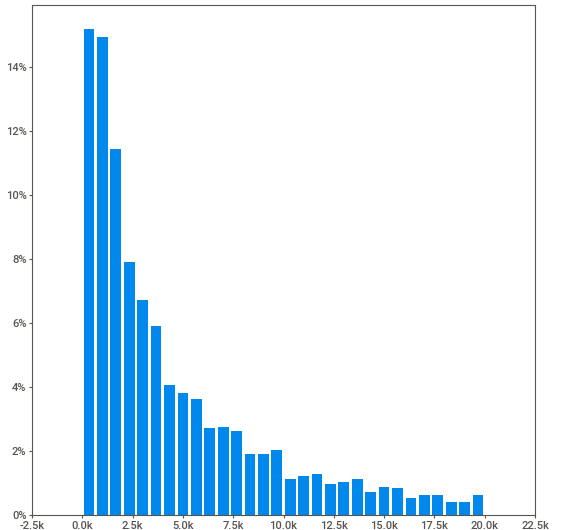
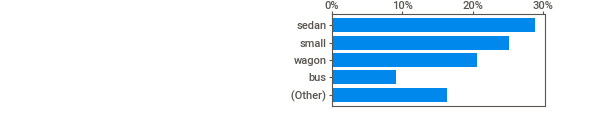
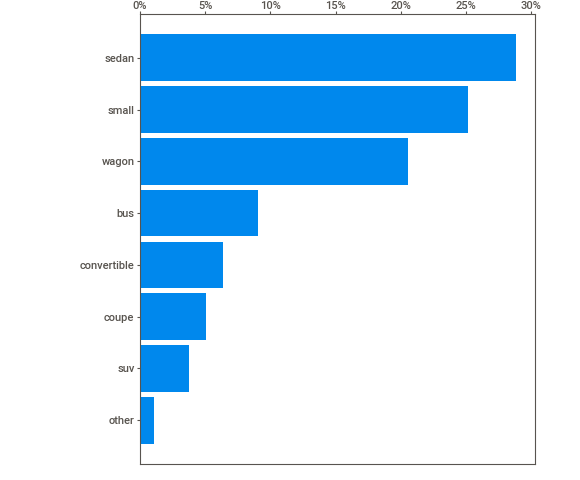
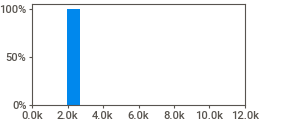
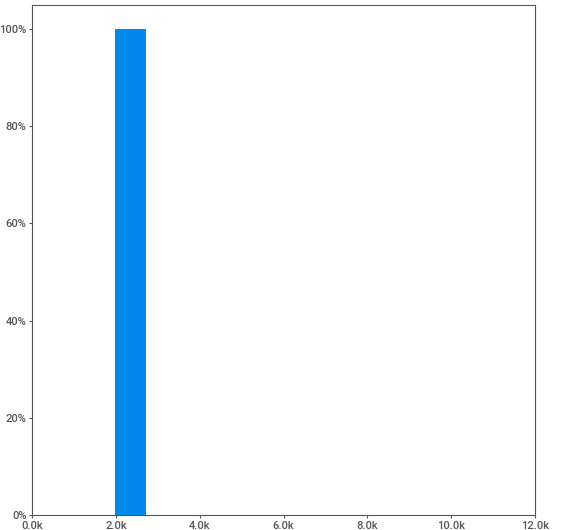
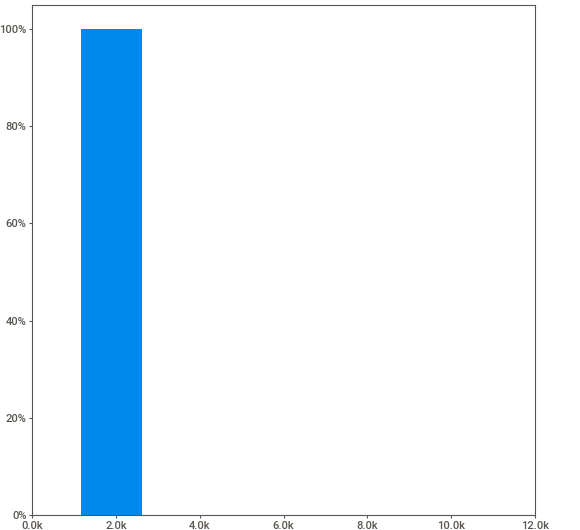
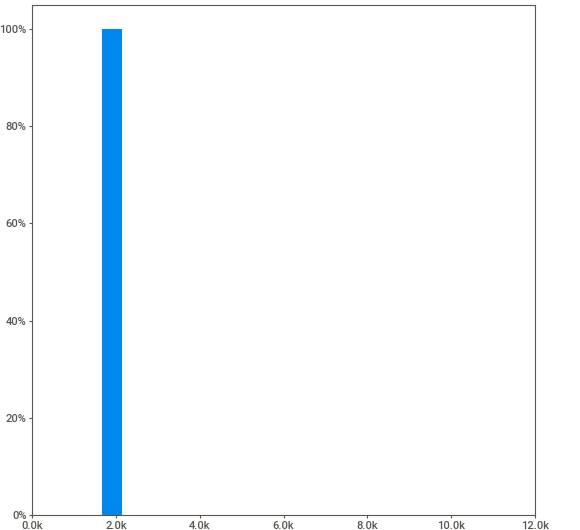
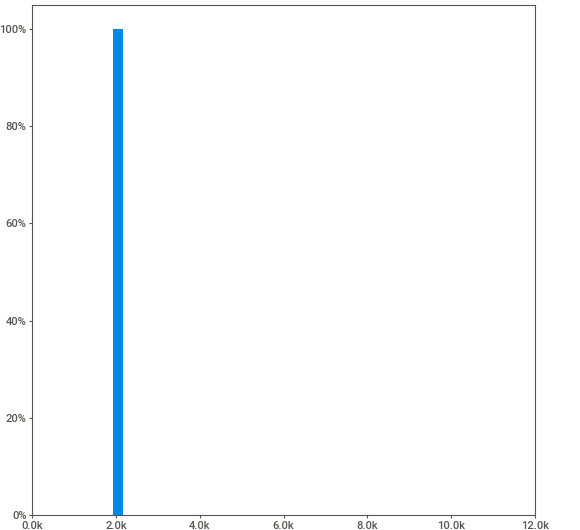
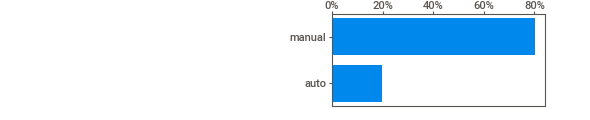
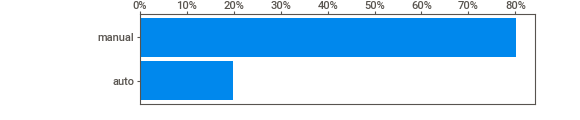
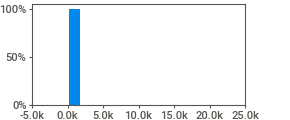
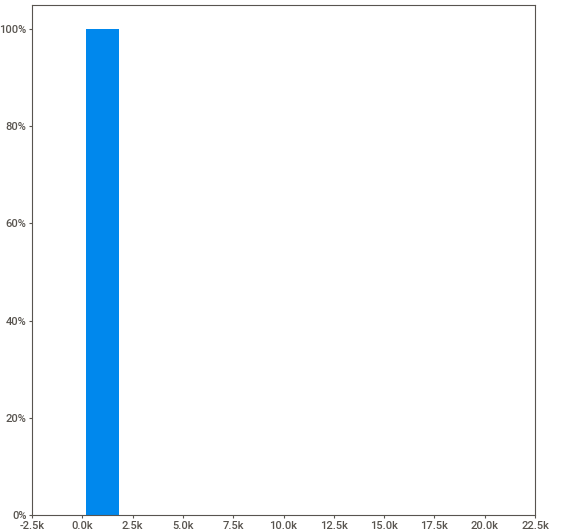
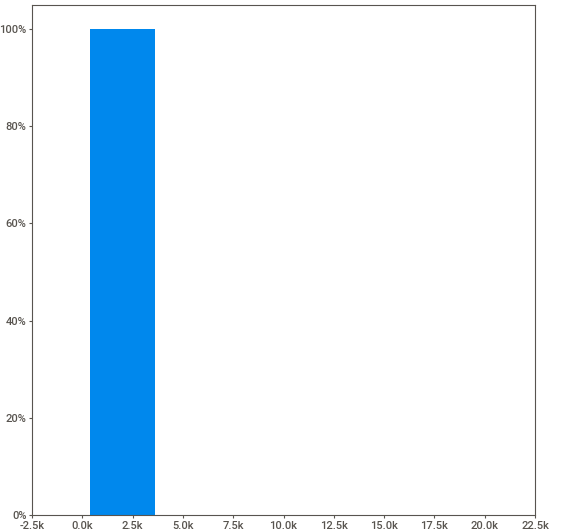
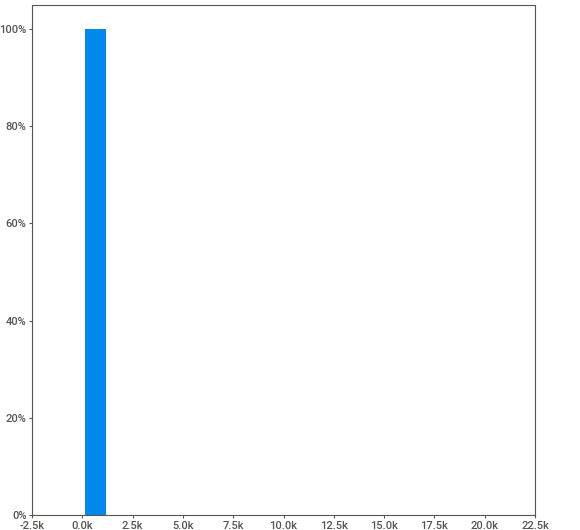
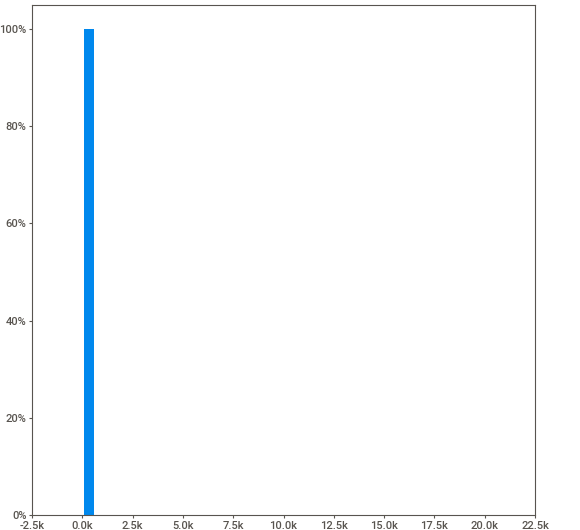
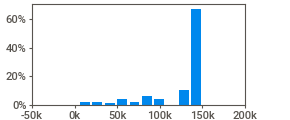
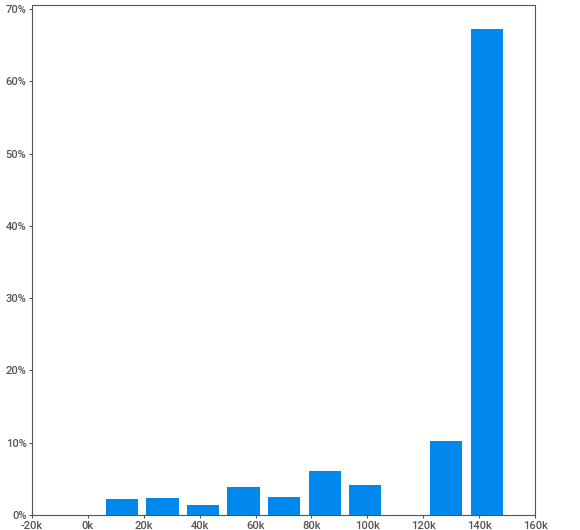
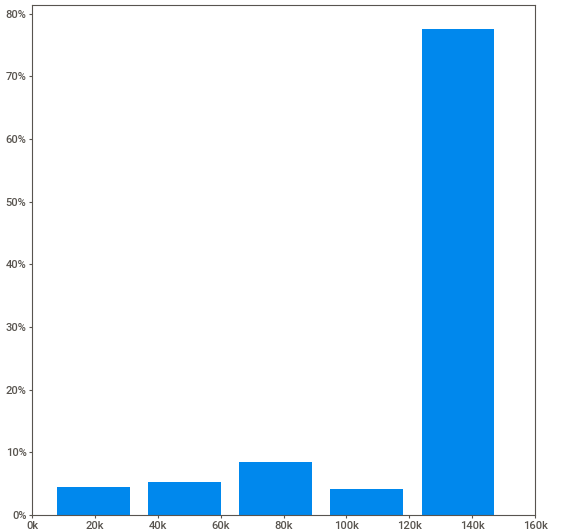
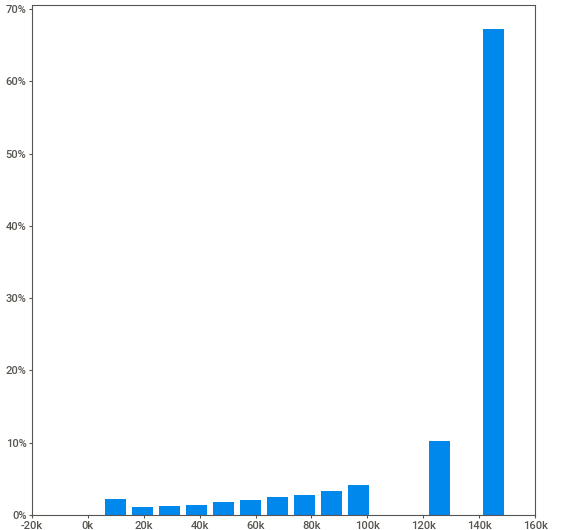
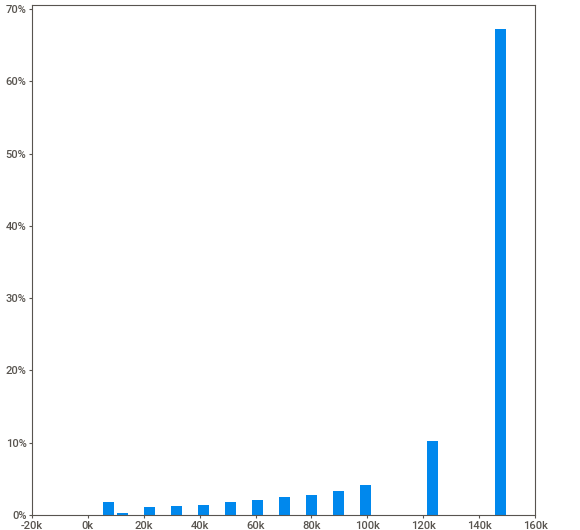
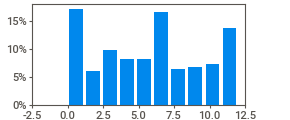
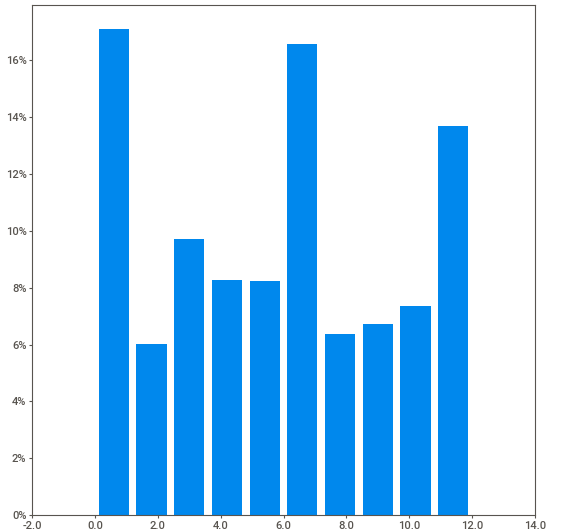
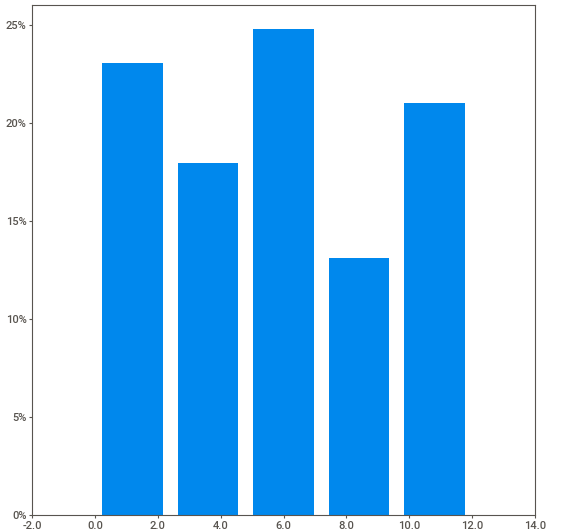
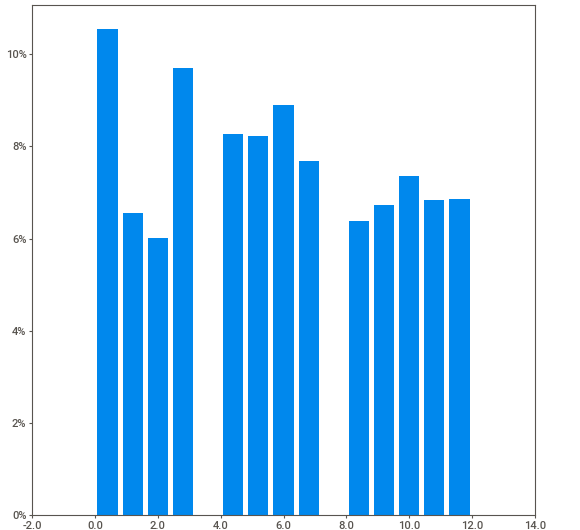
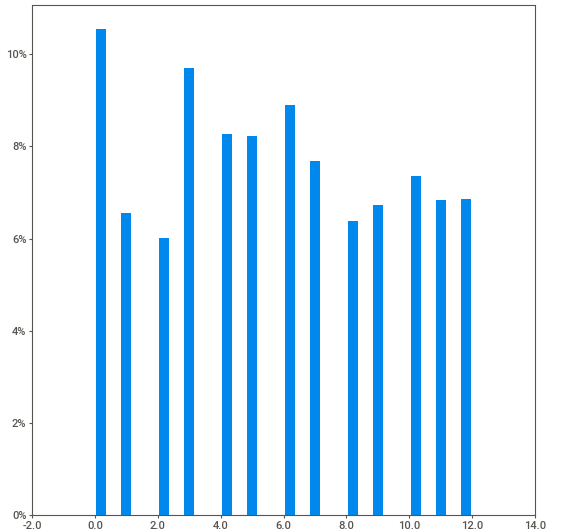
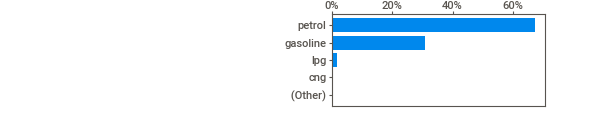
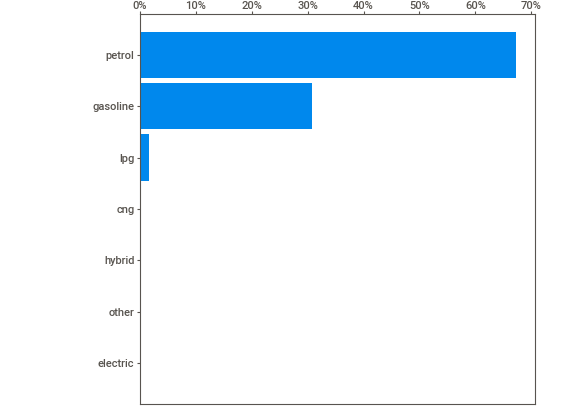
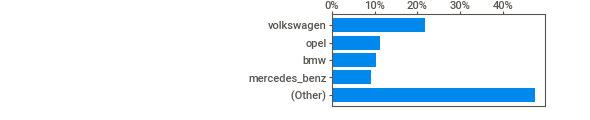
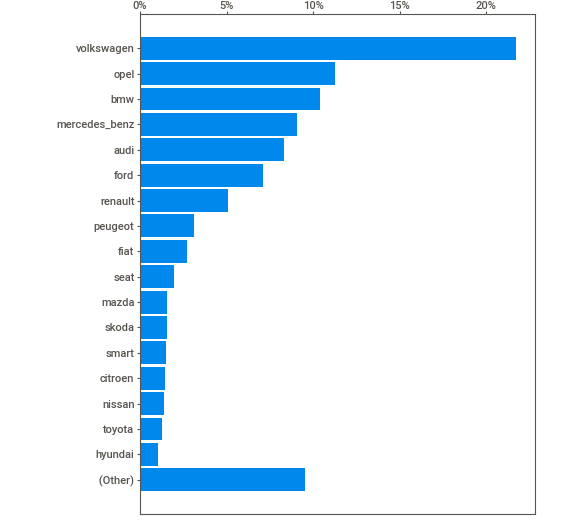
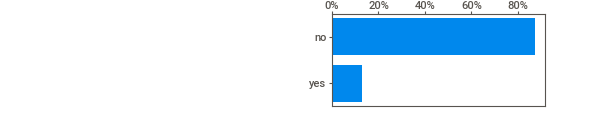
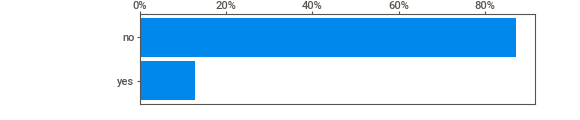
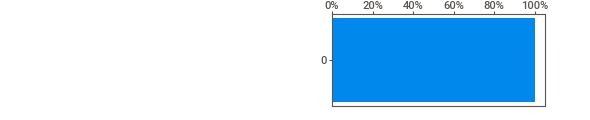
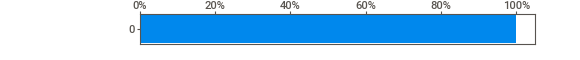
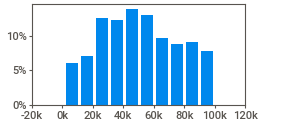
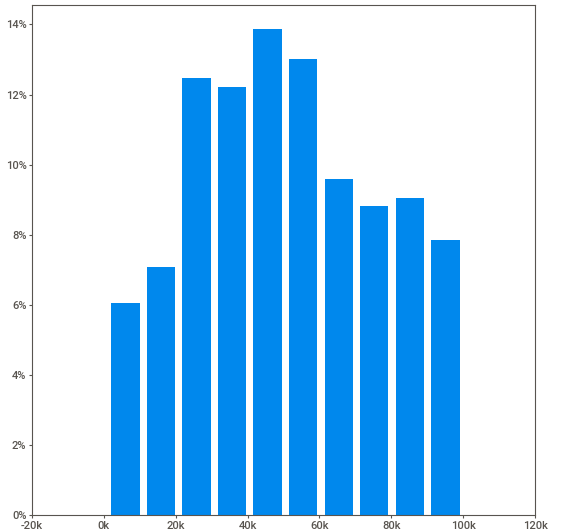
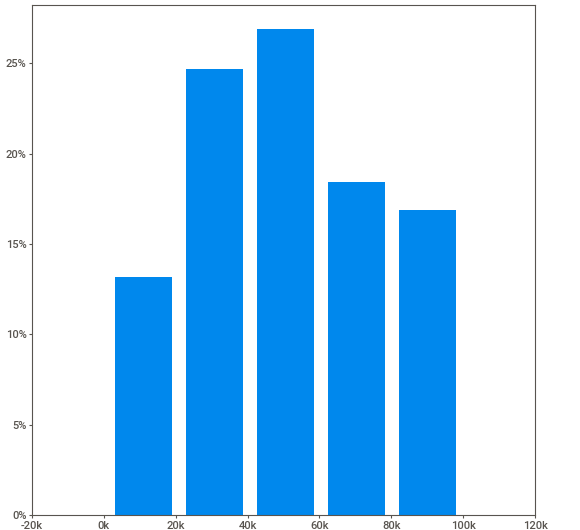
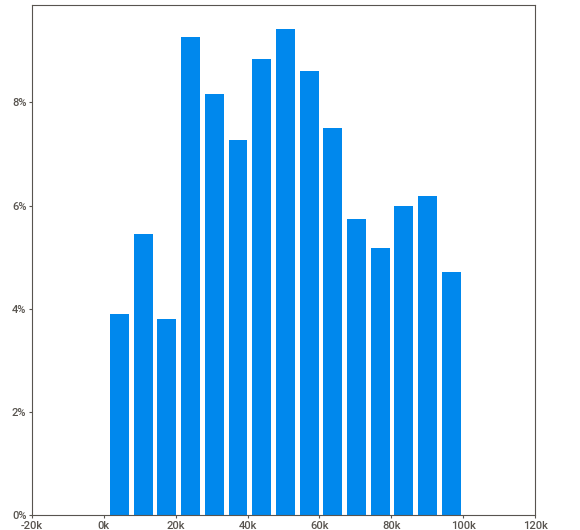
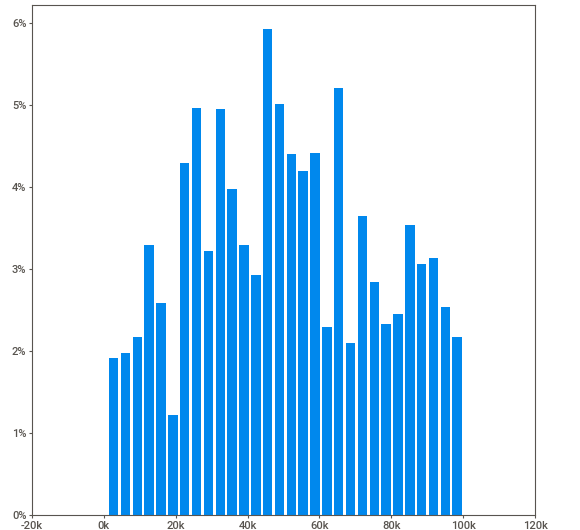
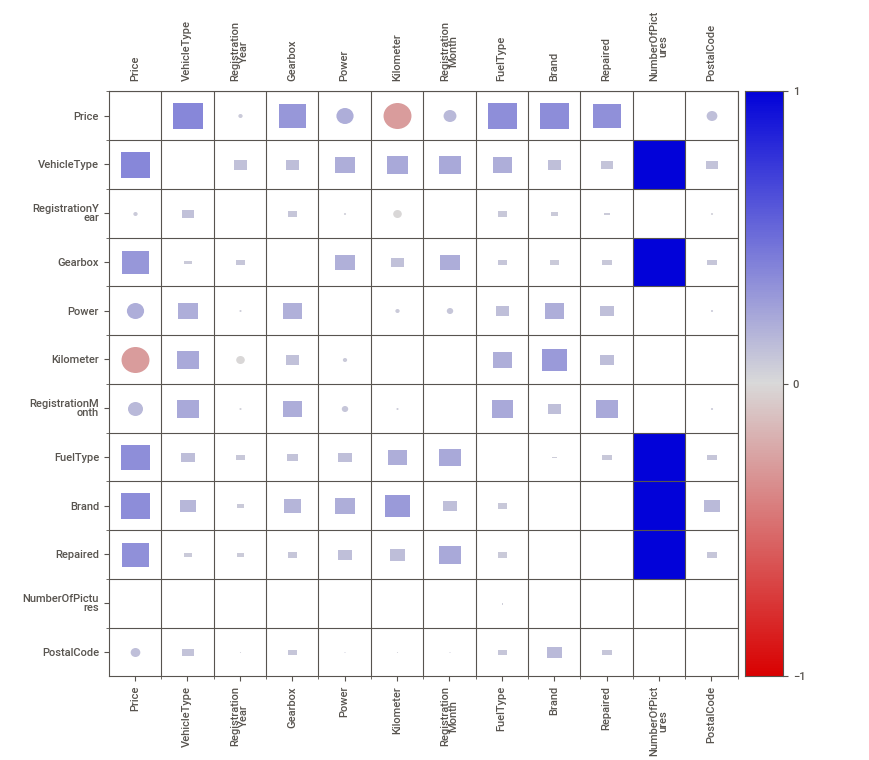
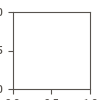

In [8]:
my_report = sv.analyze(data)
my_report.show_notebook()

## Вывод

Как видим, в данных много пропущенных значений и имеются дубликаты.

В столбцах RegistrationYear и Power имеются выбросы.

NumberOfPictures содержит нулевые значения.

Также в RegistrationMonth, Power и Price - много нулевых значений.

## 2. Обработаем данные

Удалим дубликаты

In [9]:
data.drop_duplicates(inplace=True)

В столбце Model имеется много пропусков - это один из основных признаков, влияющих на цену, восполнить эти данные мы не можем, поэтому удалим эти пропуски.

In [10]:
data.dropna(subset=['Model'], inplace=True)

Далее заполним пропуски в столбцах VehicleType, FuelType и Gearbox самым популярным значением по бренду и модели авто.

In [11]:
for brand in data.Brand.unique():
    for model in data.query('Brand == @brand ' ).Model.unique():
        try:
            data.loc[(data['Brand'] == brand) & (data['Model'] == model) & (data['VehicleType'].isna()), 'VehicleType'] = \
            data.loc[(data['Brand'] == brand) & (data['Model'] == model), 'VehicleType'].mode().iloc[0]
        except:
            pass
        
        try:
            data.loc[(data['Brand'] == brand) & (data['Model'] == model) & (data['FuelType'].isna()), 'FuelType'] = \
            data.loc[(data['Brand'] == brand) & (data['Model'] == model), 'FuelType'].mode().iloc[0]
        except:
            pass
        
        try:
            data.loc[(data['Brand'] == brand) & (data['Model'] == model) & (data['Gearbox'].isna()), 'Gearbox'] = \
            data.loc[(data['Brand'] == brand) & (data['Model'] == model), 'Gearbox'].mode().iloc[0]
        except:
            pass


Пропущенные значения в столбце Repaired заполним значением 'no', будем считать их не битыми.

In [12]:
data.Repaired.fillna('no', inplace=True)

In [13]:
data.Repaired.value_counts()

no     300952
yes     33708
Name: Repaired, dtype: int64

In [14]:
data.Gearbox.value_counts()

manual    269674
auto       64986
Name: Gearbox, dtype: int64

Проверим, остались ли пропуски

In [15]:
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Все пропуски заполнены.

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334660 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        334660 non-null  object
 1   Price              334660 non-null  int64 
 2   VehicleType        334660 non-null  object
 3   RegistrationYear   334660 non-null  int64 
 4   Gearbox            334660 non-null  object
 5   Power              334660 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          334660 non-null  int64 
 8   RegistrationMonth  334660 non-null  int64 
 9   FuelType           334660 non-null  object
 10  Brand              334660 non-null  object
 11  Repaired           334660 non-null  object
 12  DateCreated        334660 non-null  object
 13  NumberOfPictures   334660 non-null  int64 
 14  PostalCode         334660 non-null  int64 
 15  LastSeen           334660 non-null  object
dtypes: int64(7), object(

В столбце NumberOfPictures - все значения равны 0, удалим этот столбец, он не несёт никакой информации.

Также избавимся от признаков, не связанных с самим объектом - авто.

Удалим признаки:

* DateCrawled — дата скачивания анкеты из базы
* DateCreated — дата создания анкеты
* LastSeen — дата последней активности пользователя

In [17]:
columns_for_deleting = ['NumberOfPictures', 'DateCrawled', 'DateCreated', 'LastSeen']
data.drop(columns=columns_for_deleting, axis=1, inplace=True)

In [18]:
data.PostalCode//=1000

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334660 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              334660 non-null  int64 
 1   VehicleType        334660 non-null  object
 2   RegistrationYear   334660 non-null  int64 
 3   Gearbox            334660 non-null  object
 4   Power              334660 non-null  int64 
 5   Model              334660 non-null  object
 6   Kilometer          334660 non-null  int64 
 7   RegistrationMonth  334660 non-null  int64 
 8   FuelType           334660 non-null  object
 9   Brand              334660 non-null  object
 10  Repaired           334660 non-null  object
 11  PostalCode         334660 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 33.2+ MB


Признак Gearbox содержит только два значения, поэтому мы можем заменить значения на 0, 1 (привести его к бинарному виду) и преобразовать в тип bool

In [20]:
data.Gearbox.replace({'manual' : 0, 'auto' : 1}, inplace=True)
data.Repaired.replace({'no' : 0, 'yes' : 1}, inplace=True)

In [21]:
data.Gearbox = data.Gearbox.astype(bool)
data.Repaired = data.Repaired.astype(bool)

In [22]:
data.rename(columns={'Gearbox': 'GearboxAuto'}, inplace=True)

В значениях признака RegistrationMonth имеется значение 0, возможно, это ошибка в данных и вместо номера месяца 1 был взят индекс 0, что соответствует 1-му месяцу.

В данном случае мы просто заменим значения 0 на 1, т.к. остальные значения вплоть до 12-го месяца имеются.

In [23]:
data.RegistrationMonth.replace({0 : 1}, inplace=True)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334660 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              334660 non-null  int64 
 1   VehicleType        334660 non-null  object
 2   RegistrationYear   334660 non-null  int64 
 3   GearboxAuto        334660 non-null  bool  
 4   Power              334660 non-null  int64 
 5   Model              334660 non-null  object
 6   Kilometer          334660 non-null  int64 
 7   RegistrationMonth  334660 non-null  int64 
 8   FuelType           334660 non-null  object
 9   Brand              334660 non-null  object
 10  Repaired           334660 non-null  bool  
 11  PostalCode         334660 non-null  int64 
dtypes: bool(2), int64(6), object(4)
memory usage: 28.7+ MB


In [25]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
count,334660.000000,334660.000000,334660.000000,334660.000000,334660.000000,334660.000000
mean,4504.372249,2003.924024,111.372659,128562.795076,5.898138,50.224963
std,4531.457109,69.377633,185.157391,37205.638630,3.553084,25.766758
min,0.000000,1000.000000,0.000000,5000.000000,1.000000,1.000000
25%,1150.000000,1999.000000,70.000000,125000.000000,3.000000,30.000000
50%,2800.000000,2003.000000,105.000000,150000.000000,6.000000,49.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000,71.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,99.000000


В Price, RegistrationYear и Power имеются аномальные значения.

Избавимся от выбросов с помощью квантилей.

Воспользуемся функцией для удаления аномальных значений

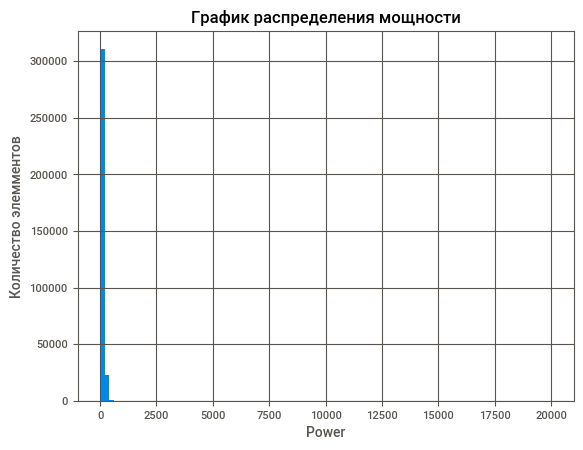

In [26]:
data.Power.hist(bins=100)
plt.title('График распределения мощности')
plt.xlabel('Power')
plt.ylabel('Количество элемментов');

В признаке Power много нулевых значений и выбросов.

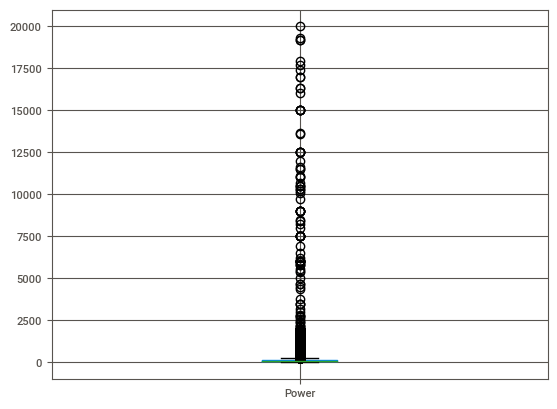

In [27]:
data.boxplot(column='Power');

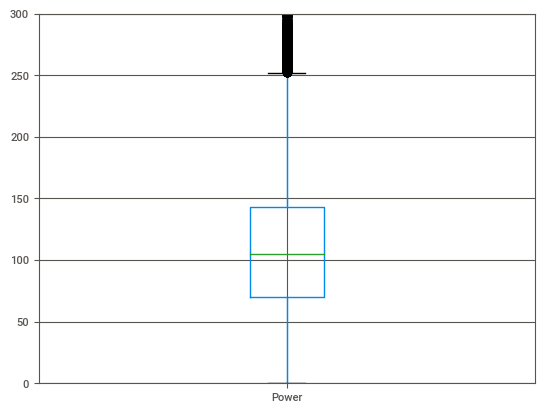

In [28]:
data.boxplot(column='Power').set_ylim([0, 300]);

В целях экономии времени и из-за отсутствия вычислительных мощностей мы просто избавимся от нулевых значений и выбросов.

Можно было бы заменить некорректные значения мощности, например значения менее 50, на медианные значения выбрав по Brand, Model, RegistrationYear и GearboxAuto, но такие вложенные циклы занимают неопределённое количество времени.

Возможно, есть более быстрые встроенные методы преобразования и модификации данных (map, apply, transform), нежели чем четверные вложенные циклы, но я пока не нашёл как их тут правильно применить. Поэтому код ниже просто закомментирован, он слишком долгий.

%%time
for brand in data.Brand.unique():
    for model in data.query('Brand == @brand ' ).Model.unique():
        for year in data.RegistrationYear.unique():
            for gear in data.GearboxAuto.unique():
                try:
                    data.loc[(data['Brand'] == brand) &\
                             (data['Model'] == model) &\
                             (data['RegistrationYear'] == year) &\
                             (data['GearboxAuto'] == gear) &\
                             (data['Power'] < 50), 'Power'] = \
                    data.loc[(data['Brand'] == brand) &\
                             (data['Model'] == model) &\
                             (data['RegistrationYear'] == year) &\
                             (data['GearboxAuto'] == gear), 'Power'].median()
                except:
                    pass


In [29]:
data = data.query('0<Power')

Аналогично удалим нулевые цены

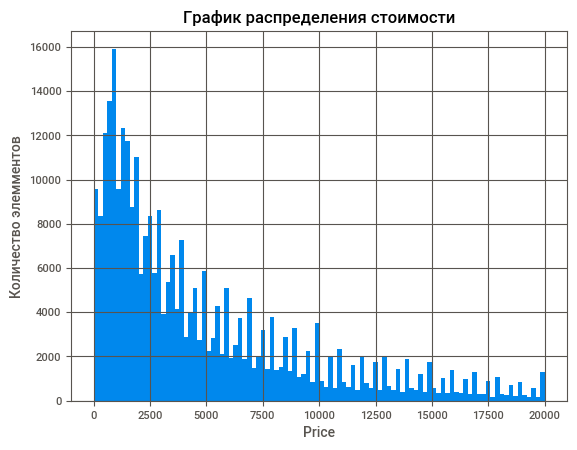

In [30]:
data.Price.hist(bins=100)
plt.title('График распределения стоимости')
plt.xlabel('Price')
plt.ylabel('Количество элемментов');

В признаке Price много нулевых значений и выбросов.

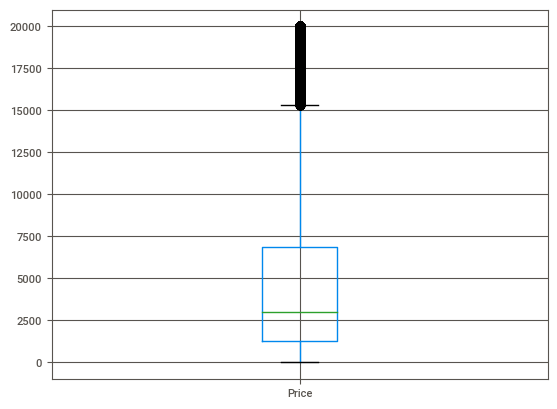

In [31]:
data.boxplot(column='Price');

In [32]:
data = data.query('0<Price')

In [33]:
data.shape

(294739, 12)

Далее удалим аномальные значения с помощью функции

In [34]:
def clip_anomaly_values(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    # lower=Q1-1.5*IQR
    lower = Q1 - 1.5 * IQR
    # upper=Q3+1.5*IQR
    upper = Q3 + 1.5 * IQR

    # df[column].clip(
    #     lower=lower,
    #     upper=upper,
    #     inplace=True
    # )
    
    df_mod = df[(df[column] >= lower) & (df[column] <= upper)]
    return df_mod

In [35]:
data = clip_anomaly_values(data, 'RegistrationYear')
data = clip_anomaly_values(data, 'Power')
data = clip_anomaly_values(data, 'Price')

In [36]:
data.shape

(272966, 12)

В RegistrationYear остались значения дат превышающие дату создания анкеты - это некорректные данные, поэтому все объекты с датой регистрации более 2016 мы удалим.

In [37]:
data = data.query('RegistrationYear < =2016')

Также переведём в категориальный признак пробег в километрах.

Изменим егдиницыы на 1000 км и переведём в целочисленный тип, чтобы упростить расчёты.

In [38]:
data.Kilometer.value_counts()

150000    180267
125000     28698
100000     11103
90000       8879
80000       7582
70000       6418
60000       5486
50000       4407
40000       3400
30000       2918
20000       2310
5000        2132
10000        580
Name: Kilometer, dtype: int64

In [39]:
data.Kilometer = data.Kilometer/1000

In [40]:
data.Kilometer = data.Kilometer.astype('int')

In [41]:
data.Kilometer.value_counts()

150    180267
125     28698
100     11103
90       8879
80       7582
70       6418
60       5486
50       4407
40       3400
30       2918
20       2310
5        2132
10        580
Name: Kilometer, dtype: int64

In [42]:
data = data.rename(columns={'Kilometer':'1000Kilometers'})

In [43]:
data.describe(include = 'all')

,Price,VehicleType,RegistrationYear,GearboxAuto,Power,Model,1000Kilometers,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
count,264180.000000,264180,264180.000000,264180,264180.000000,264180,264180.000000,264180.000000,264180,264180,264180,264180.000000
unique,NaN,8,NaN,2,NaN,246,NaN,NaN,7,39,2,NaN
top,NaN,sedan,NaN,False,NaN,golf,NaN,NaN,petrol,volkswagen,False,NaN
freq,NaN,77474,NaN,217010,NaN,23319,NaN,NaN,179774,58058,237651,NaN
mean,4169.000844,NaN,2002.904429,NaN,114.683776,NaN,130.321145,6.079843,NaN,NaN,NaN,50.670316
std,3667.797464,NaN,5.550157,NaN,44.643392,NaN,34.829697,3.485637,NaN,NaN,NaN,25.761449
min,1.000000,NaN,1986.000000,NaN,1.000000,NaN,5.000000,1.000000,NaN,NaN,NaN,1.000000
25%,1290.000000,NaN,1999.000000,NaN,75.000000,NaN,125.000000,3.000000,NaN,NaN,NaN,30.000000
50%,2900.000000,NaN,2003.000000,NaN,109.000000,NaN,150.000000,6.000000,NaN,NaN,NaN,50.000000
75%,6190.000000,NaN,2007.000000,NaN,143.000000,NaN,150.000000,9.000000,NaN,NaN,NaN,71.000000


## Вывод

Данные мы подготовили, избавились от пропусков, нулевых и аномальных значений.

Удалили ненужные признаки.

Можно приступать к разделению данных на выборки для обучения моделей.

## 3. Подготовим выборки для моделей

Разобъём датафрейм на две выборки:
- обучающую
- тестовую

В каждой выборке выделим целевой признак - target

In [44]:
# GearboxAuto и Repaired - кодировать не будем, т.к. они типа bool
num_features = ['RegistrationYear', 'Power']

cat_features_ohe = ['VehicleType', 'FuelType','1000Kilometers', 'RegistrationMonth']
cat_features_oe = ['Model', 'Brand', 'PostalCode']
cat_features =  cat_features_ohe + cat_features_oe

In [45]:
features = data.drop(['Price'], axis=1)
target = data['Price']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (198135, 11)
y_train (198135,)
X_test (66045, 11)
y_test (66045,)


Проведём порядковое кодирование категориальных признаков.

In [46]:
X_train_oe = X_train.copy()
X_test_oe = X_test.copy()

In [47]:
X_train_oe.head()
X_test_oe.head()

,VehicleType,RegistrationYear,GearboxAuto,Power,Model,1000Kilometers,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
27895,bus,2008,False,84,transporter,150,7,gasoline,volkswagen,False,83
43617,sedan,2007,False,116,b_klasse,125,5,petrol,mercedes_benz,False,41
234169,convertible,2003,False,179,tt,125,1,petrol,audi,False,85
220344,wagon,2009,False,143,3er,150,9,gasoline,bmw,False,72
206020,bus,2005,False,105,touran,150,2,gasoline,volkswagen,False,13


In [48]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder.fit(X_train_oe[cat_features])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
display(X_train_oe.head())

X_train_oe[
    encoder.get_feature_names_out()
] = encoder.transform(X_train_oe[cat_features])

display(X_train_oe.head())

# удаляем незакодированные категориальные признаки (изначальные колонки)
# X_train_oe = X_train_oe.drop(cat_features, axis=1)
# display(X_train_oe.head())


X_test_oe[
    encoder.get_feature_names_out()
] = encoder.transform(X_test_oe[cat_features])

# X_test_oe = X_test_oe.drop(cat_features, axis=1)


# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
X_train_oe[num_features] = scaler.fit_transform(X_train_oe[num_features])

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
X_test_oe[num_features] = scaler.transform(X_test_oe[num_features])

,VehicleType,RegistrationYear,GearboxAuto,Power,Model,1000Kilometers,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
95508,small,2009,False,60,2_reihe,150,11,petrol,peugeot,False,23
328556,suv,2007,False,136,outlander,80,1,petrol,mitsubishi,False,24
81490,small,1998,False,101,a3,150,10,petrol,audi,False,63
259346,small,1996,False,45,polo,150,4,petrol,volkswagen,False,67
222570,wagon,2001,False,155,a4,150,10,gasoline,audi,False,63


,VehicleType,RegistrationYear,GearboxAuto,Power,Model,1000Kilometers,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
95508,5.0,2009,False,60,8.0,12.0,10.0,6.0,25.0,False,20.0
328556,6.0,2007,False,136,167.0,8.0,0.0,6.0,22.0,False,21.0
81490,5.0,1998,False,101,28.0,12.0,9.0,6.0,1.0,False,58.0
259346,5.0,1996,False,45,173.0,12.0,3.0,6.0,37.0,False,62.0
222570,7.0,2001,False,155,29.0,12.0,9.0,2.0,1.0,False,58.0


In [49]:
X_train_oe

,VehicleType,RegistrationYear,GearboxAuto,Power,Model,1000Kilometers,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
95508,5.0,1.099596,False,-1.224995,8.0,12.0,10.0,6.0,25.0,False,20.0
328556,6.0,0.739150,False,0.477955,167.0,8.0,0.0,6.0,22.0,False,21.0
81490,5.0,-0.882853,False,-0.306298,28.0,12.0,9.0,6.0,1.0,False,58.0
259346,5.0,-1.243298,False,-1.561103,173.0,12.0,3.0,6.0,37.0,False,62.0
222570,7.0,-0.342185,False,0.903693,29.0,12.0,9.0,2.0,1.0,False,58.0
...,...,...,...,...,...,...,...,...,...,...,...
160934,4.0,1.820486,False,-0.216669,163.0,8.0,0.0,2.0,31.0,False,2.0
347691,4.0,-0.882853,True,0.791657,15.0,12.0,5.0,6.0,2.0,False,54.0
177247,5.0,-0.522408,False,-1.269809,223.0,12.0,7.0,6.0,27.0,False,55.0
197344,0.0,-3.045523,False,-1.449067,220.0,12.0,0.0,2.0,37.0,True,18.0


In [50]:
X_test_oe

,VehicleType,RegistrationYear,GearboxAuto,Power,Model,1000Kilometers,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
27895,0.0,0.919373,False,-0.687221,220.0,12.0,6.0,2.0,37.0,False,78.0
43617,4.0,0.739150,False,0.029811,47.0,11.0,4.0,6.0,20.0,False,38.0
234169,1.0,0.018260,False,1.441467,221.0,11.0,0.0,6.0,1.0,False,80.0
220344,7.0,1.099596,False,0.634806,11.0,12.0,8.0,2.0,2.0,False,67.0
206020,0.0,0.378705,False,-0.216669,218.0,12.0,1.0,2.0,37.0,False,10.0
...,...,...,...,...,...,...,...,...,...,...,...
186631,7.0,-0.702630,False,0.365919,174.0,12.0,1.0,6.0,23.0,False,88.0
331696,4.0,-0.342185,False,-0.552778,37.0,12.0,6.0,6.0,23.0,False,49.0
217237,4.0,-0.522408,False,-1.224995,33.0,12.0,9.0,2.0,20.0,False,89.0
198139,7.0,2.361153,True,0.634806,29.0,12.0,4.0,2.0,1.0,True,57.0


## Вывод

Разбили каждый датафрейм на обучающую и тестовую выборки.

## 4. Обучим модели

### 4.1. RandomForestRegressor

In [51]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

Воспользуемся make_column_transformer для преобразования категориальных признаков и стандартицации числовых.

Также воспользуемся Pipeline и RandomizedSearchCV для более быстрого поиска гиперпараметров.

Обучим модель.

In [52]:
col_transformer_rf= make_column_transformer(
    # (
    #     OneHotEncoder(drop='first', handle_unknown='ignore'), 
    #     cat_features_ohe
    # ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        cat_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)

model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

pipline_rf = make_pipeline(col_transformer_rf, model_rf)


param_grid_rf = {
    'randomforestregressor__n_estimators': range(10, 18, 2),
    'randomforestregressor__max_depth': range(3, 11, 2),
    'randomforestregressor__max_features': range(8,19,2)#,
    #'randomforestregressor__min_samples_split': (2, 3),
    #'randomforestregressor__min_samples_leaf': (1, 2, 3)
}

# получается достаточно много комбинаций гиперпараметров при переборе
# будем использовать RandomizedSearchCV, он работает на много быстрее
gs_rf = RandomizedSearchCV(
    pipline_rf, 
    param_distributions=param_grid_rf, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    random_state=RANDOM_STATE
)

gs_rf.fit(X_train_rf, y_train)

gs_rf_best_score = gs_rf.best_score_ * -1
gs_rf_best_params = gs_rf.best_params_
print(f'best_score: {gs_rf_best_score}')
print(f'best_params: {gs_rf_best_params}')

best_score: 1557.8876520001395
best_params: {'randomforestregressor__n_estimators': 12, 'randomforestregressor__max_features': 8, 'randomforestregressor__max_depth': 9}


Проверим её на тестовой выборке

%%time
rf_predictions = gs_rf.predict(X_test_rf)
metric_test = mean_squared_error(y_test, rf_predictions, squared=False)
metric_test

### 4.2. LinearRegression

In [53]:
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

In [54]:
col_transformer_lr= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'), 
        cat_features_ohe
    ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        cat_features_oe
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)

model_lr = LinearRegression()

pipline_lr = make_pipeline(col_transformer_lr, model_lr)

param_grid_lr = {'linearregression__fit_intercept':[True, False]}


# получается достаточно много комбинаций гиперпараметров при переборе
# будем использовать RandomizedSearchCV, он работает на много быстрее
gs_lr = RandomizedSearchCV(
    pipline_lr,
    param_distributions=param_grid_lr,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    random_state=RANDOM_STATE
)

gs_lr.fit(X_train_lr, y_train)

gs_lr_best_score = gs_lr.best_score_ * -1
gs_lr_best_params = gs_lr.best_params_
print(f'best_score: {gs_lr_best_score}')
print(f'best_params: {gs_lr_best_params}')

best_score: 2188.3985493426817
best_params: {'linearregression__fit_intercept': True}


Проверим на тестовой выборке

%%time
lr_predictions = gs_lr.predict(X_test_lr)
metric_test = mean_squared_error(y_test, lr_predictions, squared=False)
metric_test

### 4.3. LightGBM

In [55]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()

In [56]:
col_transformer_lgbm= make_column_transformer(
    # (
    #     OneHotEncoder(drop='first', handle_unknown='ignore'), 
    #     cat_features_ohe
    # ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        cat_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)

model_lgbm = LGBMRegressor()

pipline_lgbm = make_pipeline(col_transformer_lgbm, model_lgbm)

param_grid_lgbm = {'lgbmregressor__num_leaves':[31, 100, 200], 
                   'lgbmregressor__learning_rate':[0.1, 0.3, 0.5]}


# получается достаточно много комбинаций гиперпараметров при переборе
# будем использовать RandomizedSearchCV, он работает на много быстрее
gs_lgbm = RandomizedSearchCV(
    pipline_lgbm,
    param_distributions=param_grid_lgbm,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    random_state=RANDOM_STATE
)

gs_lgbm.fit(X_train_lgbm, y_train)
# , eval_metric='rmse', categorical_feature=cat_features_ohe+cat_features_oe

gs_lgbm_best_score = gs_lgbm.best_score_ * -1
gs_lgbm_best_params = gs_lgbm.best_params_
print(f'best_score: {gs_lgbm_best_score}')
print(f'best_params: {gs_lgbm_best_params}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 198135, number of used features: 11
[LightGBM] [Info] Start training from score 4167.510258
best_score: 1277.4554802898497
best_params: {'lgbmregressor__num_leaves': 200, 'lgbmregressor__learning_rate': 0.3}


Проверим на тестовой выборке

%%time
lgbm_predictions = gs_lgbm.predict(X_test_lgbm)
metric_test = mean_squared_error(y_test, lgbm_predictions, squared=False)
metric_test

### 4.4. CatBoost

In [57]:
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

In [58]:
model_cb = CatBoostRegressor(loss_function='RMSE', iterations=300)
model_cb.fit(X_train_cb, y_train, cat_features=cat_features, verbose=50)

Learning rate set to 0.251304
0:	learn: 3094.1047568	total: 222ms	remaining: 1m 6s
50:	learn: 1395.4117739	total: 3.84s	remaining: 18.7s
100:	learn: 1339.5780652	total: 7.63s	remaining: 15s
150:	learn: 1313.4326891	total: 11.6s	remaining: 11.4s
200:	learn: 1295.9860164	total: 15.7s	remaining: 7.71s
250:	learn: 1283.3251877	total: 19.6s	remaining: 3.83s
299:	learn: 1272.7450800	total: 23.3s	remaining: 0us


In [59]:
cb_best_score = model_cb.best_score_
print(f'best_score: {cb_best_score}')

best_score: {'learn': {'RMSE': 1272.7450799511532}}


Проверим на тестовой выборке

%%time
cb_predictions = model_cb.predict(X_test_cb)
metric_test = mean_squared_error(y_test, cb_predictions, squared=False)
metric_test

### 4.5. Проверка Dummy моделью

Вычислим RMSE с помощью модели Dummy и стратегии выбора среднего значения.

In [60]:
dummy = DummyRegressor(strategy='mean')

In [61]:
dummy.fit(X_train, y_train);

In [62]:
print(f'RMSE Dummy модели на тестовой выборке:\n{mean_squared_error(y_test, dummy.predict(X_test), squared=False)}')

RMSE Dummy модели на тестовой выборке:
3666.5496328454665


## Вывод

RMSE Dummy модели оказался хуже всех наших моделей, что подтверждает их адекватность.

## 5. Проанализируем наши модели и выберем подходящую

In [63]:
all_models = ['RandomForestRegressor', 'LinearRegression', 'LGBMRegressor', 'CatBoostRegressor']
train_time = []
predict_time = []
train_RMSE = []

models = {RandomForestRegressor(random_state=RANDOM_STATE) : [{'n_estimators': 10,\
                                                               'max_depth': 9,\
                                                               'max_features': 12}],         
          LinearRegression() : {'fit_intercept': True},
          LGBMRegressor() : {'num_leaves': 200, 'learning_rate': 0.3},
          CatBoostRegressor() : {'loss_function': 'RMSE', 'iterations': 300}
         }

In [64]:
model = RandomForestRegressor(random_state=RANDOM_STATE,\
                              n_estimators= 12,\
                              max_depth=9,\
                              max_features=8,\
                              n_jobs=-1)      

start = time.time() # точка отсчета времени
model.fit(X_train_oe, y_train)
end = time.time() - start # время работы программы
train_time.append(format(end, '.2f'))

start = time.time() # точка отсчета времени
predict = model.predict(X_train_oe)
end = time.time() - start # время работы программы
predict_time.append(format(end, '.2f'))

rmse = mean_squared_error(y_train, predict, squared=False)
train_RMSE.append(format(rmse, '.2f'))

In [65]:
model = LinearRegression(fit_intercept=True, n_jobs=-1)

start = time.time() # точка отсчета времени
model.fit(X_train_oe, y_train)
end = time.time() - start # время работы программы
train_time.append(format(end, '.2f'))

start = time.time() # точка отсчета времени
predict = model.predict(X_train_oe)
end = time.time() - start # время работы программы
predict_time.append(format(end, '.2f'))

rmse = mean_squared_error(y_train, predict, squared=False)
train_RMSE.append(format(rmse, '.2f'))

In [66]:
model = LGBMRegressor(num_leaves=200, learning_rate=.3, n_jobs=-1, random_state=RANDOM_STATE)

start = time.time() # точка отсчета времени
model.fit(X_train_oe, y_train)
end = time.time() - start # время работы программы
train_time.append(format(end, '.2f'))

start = time.time() # точка отсчета времени
predict = model.predict(X_train_oe)
end = time.time() - start # время работы программы
predict_time.append(format(end, '.2f'))

rmse = mean_squared_error(y_train, predict, squared=False)
train_RMSE.append(format(rmse, '.2f'))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 198135, number of used features: 11
[LightGBM] [Info] Start training from score 4167.510258


In [67]:
model = CatBoostRegressor(loss_function='RMSE', iterations=300, random_state=RANDOM_STATE, verbose=False)

start = time.time() # точка отсчета времени
model.fit(X_train_oe, y_train)
end = time.time() - start # время работы программы
train_time.append(format(end, '.2f'))

start = time.time() # точка отсчета времени
predict = model.predict(X_train_oe)
end = time.time() - start # время работы программы
predict_time.append(format(end, '.2f'))

rmse = mean_squared_error(y_train, predict, squared=False)
train_RMSE.append(format(rmse, '.2f'))

In [68]:
total = pd.DataFrame({'Models': all_models,
                      'Train_time(sec)': train_time,
                      'Predict_Time(sec)': predict_time,
                      'Train_RMSE': train_RMSE
                     })
total

,Models,Train_time(sec),Predict_Time(sec),Train_RMSE
0,RandomForestRegressor,0.29,0.05,1518.94
1,LinearRegression,0.04,0.02,2297.02
2,LGBMRegressor,0.63,0.10,1028.75
3,CatBoostRegressor,2.27,0.10,1267.11


## 6. Проверим лучшую модель на тестовой выборке

In [69]:
model = LGBMRegressor(num_leaves=200, learning_rate=.3, n_jobs=-1, random_state=RANDOM_STATE)
model.fit(X_train_oe, y_train)
predict = model.predict(X_test_oe)
rmse = mean_squared_error(y_test, predict, squared=False)
print(f'RMSE на тестовой выборке {rmse:.2f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 198135, number of used features: 11
[LightGBM] [Info] Start training from score 4167.510258
RMSE на тестовой выборке 1289.25


## Вывод

Все рассмотренные модели удоовлетворяют требованиям заказчика, даже наихудшая по метрике RMSE модель LinearRegression показала результат не превышающий 2500.

Наилучшая в плане точности предсказаний - LGBMRegressor, а немного от неё отстала модель CatBoostRegressor.

Оптимальным вариантом по качеству предсказаний, времени обучения и времени предсказаний будет модель **LGBMRegressor**